Nur nen test zu autoencodern

In [2]:
%config InlineBackend.figure_format = 'retina'

In [8]:
import tensorflow.keras as keras
from keras import layers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

In [3]:
# load image data, remove class and reshape 
data = pd.read_pickle('images_df_numerical.pkl')['data'].to_numpy()
image_size = data[0].size
samples = data.size
image_shape = (216,334,3) # height, width , channel
# reshape every row to the image and scale to 0-1
data = [row.reshape(image_shape).astype('float32')/255. for row in data]
x_train, x_test = train_test_split(data,test_size=0.2) 
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)
print("Total Number of Images:\t\t",len(data))
print("Number of Images for Training:\t",len(x_train))
print("Number of Images for Test:\t",len(x_test))

Total Number of Images:		 1531
Number of Images for Training:	 1224
Number of Images for Test:	 307


In [11]:
# cnn as en/decoder
shapes = image_shape

input_img = keras.Input(shape=shapes)

x = layers.Conv2D(64, (7, 7), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (2, 2), activation='relu', padding='same')(x)
encoded = layers.Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# Decoder
x = layers.Conv2D(32, (1, 1), activation='relu', padding='same')(encoded)
x = layers.Conv2D(32, (2, 2), activation='relu', padding='same')(x)
#x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(shapes[2], (7, 7), activation='sigmoid', padding='same')(x)
#add cropping layer to match shapes
decoded=layers.Cropping2D(cropping=((0,0),(0,2)))(x)

autoencoder = keras.Model(input_img,decoded)
# compile autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

# train on data
autoencoder.fit(x_train,x_train,
                epochs=10,
                batch_size=100,
                shuffle=True,
                validation_split=0.2
               )

# save model
autoencoder.save('./autoencoder_files/test_autoencoder_cnn.keras')

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 216, 334, 3)]     0         
                                                                 
 conv2d_53 (Conv2D)          (None, 216, 334, 64)      9472      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 108, 167, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_54 (Conv2D)          (None, 108, 167, 32)      18464     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 54, 84, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 54, 84, 32)        9248

In [4]:
# predict some images
autoencoder = keras.saving.load_model('./autoencoder_files/autoencoder_cnn_denoise_v6.keras')
decoded_imgs = autoencoder.predict(x_test)

2023-12-16 18:41:58.708014: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-16 18:41:58.708037: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-16 18:41:58.708044: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-16 18:41:58.708074: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-16 18:41:58.708088: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-12-16 18:41:59.806987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 5s 414ms/step


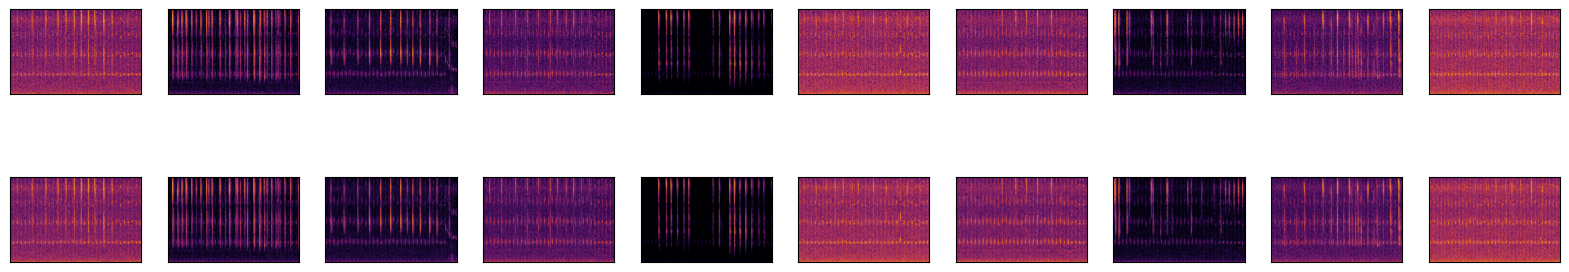

In [10]:
# display some of the images vs reconstruction
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cv2.cvtColor(x_test[i].reshape(image_shape), cv2.COLOR_BGR2RGB))
    #plt.color()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cv2.cvtColor(decoded_imgs[i].reshape(image_shape), cv2.COLOR_BGR2RGB))
    #plt.color()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig("test_autoencoder_cnn_reconstruction.png",dpi=600)